<a href="https://colab.research.google.com/github/element-fi/elf-simulations/blob/dp_mart_agents/examples/notebooks/fred_louie_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hyperdrive [NAME] simulation
We use the following setup:
- TBD
* variable rate:
    * step function
    * rate changes every 3 months
    * 

For details on the simulation framework, please see our <a href="https://elfpy.element.fi/">simulation documentation</a>

### Install repo requirements & import packages

In [102]:
# test: skip-cell
try: # install dependencies only if running on google colab
    import google.colab # check if running in colab
    !pip install -r https://raw.githubusercontent.com/element-fi/elf-simulations/main/requirements-3.8.txt 
    !pip install git+https://github.com/element-fi/elf-simulations.git
except:
    print("running locally & trusting that you have the dependencies installed")

running locally & trusting that you have the dependencies installed


In [103]:
from __future__ import annotations

import time as time

import numpy as np
from numpy.random._generator import Generator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from elfpy import WEI
from elfpy.types import MarketActionType, MarketAction, Quantity, TokenType, MarketDeltas
from elfpy.simulators import Simulator
from elfpy.agent import Agent
from elfpy.markets import Market
from elfpy.utils import sim_utils
import elfpy.utils.time as time_utils
import elfpy.utils.outputs as output_utils
import elfpy.utils.post_processing as post_processing
from elfpy.types import MarketState, StretchedTime, Config
from elfpy.utils.outputs import get_gridspec_subplots

### Setup experiment parameters

In [104]:
config = Config()

# General config parameters
config.title = "Hyperdrive smart agent demo"
config.pricing_model_name = "Hyperdrive" # can be yieldspace or hyperdrive

config.num_trading_days = 20#1095 # Number of simulated trading days
config.num_blocks_per_day = 5#7200 # Blocks in a given day (7200 means ~12 sec per block)
config.num_position_days = 10#90 # How long a token reaches maturity

config.trade_fee_percent = 0.05 # fee percent collected on trades
config.redemption_fee_percent = 0.05 # fee collected on the spread of the flat portion

config.target_pool_apr = 0.01 # target pool APR of the initial market after the LP
config.target_liquidity = 500_000_000 # target total liquidity of the initial market, before any trades

config.log_level = output_utils.text_to_log_level("INFO") # Logging level, should be in ["DEBUG", "INFO", "WARNING"]
config.log_filename = "./frida_n_louie.log" # Output filename for logging

config.shuffle_users = True

# Notebook specific parameters
num_fridas = 10
num_louies = 20 * num_fridas
num_agents = num_fridas + num_louies # int specifying how many agents you want to simulate
trade_chance = 1 # 1 / (config.num_trading_days * num_agents) # on a given block, an agent will trade with probability `trade_chance`

# Louie Laembaesaurus parameters
louie_budget_mean = 375_000
louie_budget_std = 25_000

louie_budget_max = 1_000_000
louie_budget_min = 1_000

louie_trade_minimum = 5_000

# Frida Fukuiraptor parameters
frida_budget_mean = 50_000
frida_budget_std = 500

frida_budget_max = 20_000
frida_budget_min = 1_000

frida_risk_min = 0.0
frida_risk_max = 0.06
frida_risk_mean = 0.02
frida_risk_std = 0.01

frida_trade_size = 50_000 # realistic trade size based off an estimate of a loan

# Lenny Lambaesaurus (takes out a loan and hedges it exactly by shorting)

### Setup agents

In [105]:
class FixedFrida(Agent):
    """
    Agent that paints & opens fixed rate borrow positions
    She hedges her loan
    """

    def __init__(self, rng: Generator, trade_chance: float, risk_threshold: float, wallet_address: int, budget: int = 10_000) -> None:
        """Add custom stuff then call basic policy init"""
        self.trade_chance = trade_chance
        self.risk_threshold = risk_threshold
        self.rng = rng
        super().__init__(wallet_address, budget)
        self.name = "FixedFrida"

    def action(self, market: Market) -> list[MarketAction]:
        """Implement a Fixed Frida user strategy

        I'm an actor with a high risk threshold
        I'm willing to open up a fixed-rate borrow (aka a short) if the fixed rate is ~2% higher than the variable rate
            approx means gauss mean=0.02; std=0.005, clipped at 0, 5
        I will never close my short until the simulation stops
            UNLESS my short reaches the token duration mark (e.g. 6mo)
            realistically, people might leave them hanging
        I have total budget of 2k -> 250k (gauss mean=75k; std=50k, i.e. 68% values are within 75k +/- 50k)
        I only open one short at a time

        Parameters
        ----------
        market : Market
            the trading market

        Returns
        -------
        action_list : list[MarketAction]
        """
        # Any trading at all is based on a weighted coin flip -- they have a trade_chance% chance of executing a trade
        gonna_trade = self.rng.choice([True, False], p=[self.trade_chance, 1-self.trade_chance])
        if not gonna_trade:
            return []
        
        action_list = []
        for short_time in self.wallet.shorts: # loop over shorts
            if (market.time - short_time) >= market.annualized_position_duration: # if any short is mature
                trade_amount = self.wallet.shorts[short_time].balance # close the whole thing
                trade_amount_in_base = trade_amount * market.spot_price
                years_remaining = time_utils.get_years_remaining(
                    market_time=market.time, mint_time=short_time, position_duration_years=market.position_duration.days / 365
                )
                minimum_price_accepted = 1 / ( 1 + market.market_state.vault_apr * years_remaining) # between 0 and 1
                minimum_amount_accepted = (
                    trade_amount # in PTs
                    * minimum_price_accepted # between 0 and 1
                ) # result is between 0 and trade_amount
                action_list += [
                    self.create_agent_action(
                        action_type=MarketActionType.CLOSE_SHORT,
                        trade_amount=trade_amount, # in PTs
                        mint_time=short_time,
                        minimum_amount_accepted=minimum_amount_accepted # in base
                    )
                ]

        short_balances = [short.balance for short in self.wallet.shorts.values()]
        has_opened_short = bool(any(short_balance > 0 for short_balance in short_balances))
        # only open a short if the fixed rate is 0.02 or more lower than variable rate
        if (market.rate - market.market_state.vault_apr) < self.risk_threshold and not has_opened_short: 
            trade_amount = self.get_max_short(market) # maximum amount the agent can short given the market and the agent's wallet
            trade_amount = np.minimum(frida_trade_size, trade_amount) # limit the trade size to 50k
            if trade_amount > WEI:
                action_list += [
                    self.create_agent_action(
                        action_type=MarketActionType.OPEN_SHORT,
                        trade_amount=trade_amount,
                        mint_time=market.time,
                    )
                ]

        return action_list

In [106]:
class LongLouie(Agent):
    """
    Long-nosed agent that opens longs
    """

    def __init__(self, rng: Generator, trade_chance: float, risk_threshold: float, wallet_address: int, budget: int = 10_000) -> None:
        """Add custom stuff then call basic policy init"""
        self.trade_chance = trade_chance
        self.risk_threshold = risk_threshold
        self.rng = rng
        super().__init__(wallet_address, budget)
        self.name = "LongLouie"

    def action(self, market: Market) -> list[MarketAction]:
        """Implement a Long Louie user strategy

        I'm not willing to open a long if it will cause the fixed-rate apr to go below the variable rate
            I simulate the outcome of my trade, and only execute on this condition
        I only close if the position has matured
        I have total budget of 2k -> 250k (gauss mean=75k; std=50k, i.e. 68% values are within 75k +/- 50k)
        I only open one long at a time

        Parameters
        ----------
        market : Market
            the trading market

        Returns
        -------
        action_list : list[MarketAction]
        """
        # Any trading at all is based on a weighted coin flip -- they have a trade_chance% chance of executing a trade
        gonna_trade = self.rng.choice([True, False], p=[self.trade_chance, 1-self.trade_chance])
        if not gonna_trade:
            return []
        
        action_list = []
        for long_time in self.wallet.longs: # loop over longs
            if (market.time - long_time) >= market.annualized_position_duration: # if any long is mature
                trade_amount = self.wallet.longs[long_time].balance # close the whole thing
                action_list += [
                    self.create_agent_action(
                        action_type=MarketActionType.CLOSE_LONG,
                        trade_amount=trade_amount,
                        mint_time=long_time
                    )
                ]

        long_balances = [long.balance for long in self.wallet.longs.values()]
        has_opened_long = bool(any(long_balance > 0 for long_balance in long_balances))
        # only open a long if the fixed rate is higher than variable rate
        if (market.rate - market.market_state.vault_apr) > self.risk_threshold and not has_opened_long: # risk_threshold = 0
            # FIXME: get_max_long should be able to take an optional argument that is a max target apr
            total_bonds_to_match_vault_apr = market.pricing_model.calc_bond_reserves(
                target_apr=market.market_state.vault_apr, # fixed rate targets the variable rate
                time_remaining=market.position_duration,
                market_state=market.market_state
            )
            # get the delta bond amount & convert units
            new_bonds_to_match_vault_apr = (market.market_state.bond_reserves - total_bonds_to_match_vault_apr) * market.spot_price
            # divide by 2 to adjust for changes in share reserves when the trade is executed
            adjusted_bonds = new_bonds_to_match_vault_apr / 2
            adjusted_base = adjusted_bonds * market.spot_price
            # get the maximum amount the agent can long given the market and the agent's wallet
            max_trade_amount_in_base = self.get_max_long(market)
            minimum_price_accepted = 1 / ( 1 + market.market_state.vault_apr * (market.position_duration.days/365)) # [0,1]
            trade_amount_in_base = np.maximum(1e-18,np.minimum(max_trade_amount_in_base, adjusted_base)) # don't want to trade more than the agent has or more than the market can handle
            if trade_amount_in_base > louie_minimum_trade:
                # FIXME: run Matt's function to calculate 
                # FIXME: minimum amount for buy PTs (either open long or close short) and maximum in for sell PTs (open short or close long)
                action_list += [
                    self.create_agent_action(
                        action_type=MarketActionType.OPEN_LONG, # in base
                        trade_amount=trade_amount_in_base, # $250k
                        mint_time=market.time,
                        minimum_amount_accepted=trade_amount_in_base/minimum_price_accepted # no slippage estimate where fixed rate = vault apr
                        # minimum_amount_accepted=best_case_slippy  #trade_amount_in_base/minimum_price_accepted # in PTs 
                    ) 
                ]

        return action_list

In [107]:
class LPAgent(Agent):
    """Adds a large LP"""
    def action(self, market: Market):
        """implement user strategy"""
        if self.wallet.lp_tokens > 0: # has already opened the lp
            action_list = []
        else:
            action_list = [
                self.create_agent_action(
                    action_type=MarketActionType.ADD_LIQUIDITY, trade_amount=self.budget
                ),
            ]
        return action_list

In [108]:

def get_example_agents(rng: Generator, num_fridas: int, num_louies: int, existing_agents: int = 0) -> list[Agent]:
    """Instantiate a set of custom agents"""
    agents = []
    for address in range(existing_agents, existing_agents + num_fridas):
        risk_threshold = np.maximum(frida_risk_min, np.minimum(frida_risk_max, rng.normal(loc=frida_risk_mean, scale=frida_risk_std)))
        budget = np.maximum(frida_budget_min, np.minimum(250_000, rng.normal(loc=frida_budget_mean, scale=frida_budget_std)))
        agent = FixedFrida(
            rng=rng,
            trade_chance=trade_chance,
            risk_threshold=risk_threshold,
            wallet_address=address,
            budget=budget,
        )
        agent.log_status_report()
        agents += [agent]
    existing_agents += len(agents)
    for address in range(existing_agents, existing_agents + num_louies):
        risk_threshold = 0.0
        budget = np.maximum(louie_budget_min, np.minimum(250_000, rng.normal(loc=louie_budget_mean, scale=louie_budget_std)))
        agent = LongLouie(
            rng=rng,
            trade_chance=trade_chance,
            risk_threshold=risk_threshold,
            wallet_address=address,
            budget=budget,
        )
        agent.log_status_report()
        agents += [agent]
    return agents


### Define vault apr process

In [109]:
# Define the vault apr
vault_apr = np.array([0.01]*config.num_trading_days)
#vault_apr[config.num_trading_days//2:] = 0.05
config.vault_apr = vault_apr.tolist()
config.freeze()

### Setup simulation objects

In [110]:
# define root logging parameters
output_utils.setup_logging(log_filename=config.log_filename, log_level=config.log_level)

# instantiate the pricing model
pricing_model = sim_utils.get_pricing_model(config.pricing_model_name)

# instantiate the market
position_duration = StretchedTime(
    days=config.num_position_days,
    time_stretch=pricing_model.calc_time_stretch(config.target_pool_apr),
    normalizing_constant=config.num_position_days,
)

init_target_liquidity = 1 # tiny amount for setting up apr
share_reserves_direct, bond_reserves_direct = pricing_model.calc_liquidity(
    market_state=MarketState(
        share_price=config.init_share_price,
        init_share_price=config.init_share_price
    ),
    target_liquidity=init_target_liquidity,
    target_apr=config.target_pool_apr * config.num_position_days / 365,
    position_duration=position_duration,
)
market = Market(
    pricing_model=pricing_model,
    market_state=MarketState(
        share_reserves=share_reserves_direct,
        bond_reserves=bond_reserves_direct,
        base_buffer=0,
        bond_buffer=0,
        lp_reserves=init_target_liquidity / config.init_share_price,
        init_share_price=config.init_share_price,  # u from YieldSpace w/ Yield Baring Vaults
        share_price=config.init_share_price,  # c from YieldSpace w/ Yield Baring Vaults
        vault_apr=config.vault_apr[0],  # yield bearing source apr
        trade_fee_percent=config.trade_fee_percent,  # g
        redemption_fee_percent=config.redemption_fee_percent,
    ),
    position_duration=position_duration
)

# Instantiate the initial LP agent.
current_market_liquidity = market.pricing_model.calc_total_liquidity_from_reserves_and_price(
    market_state=market.market_state, share_price=market.market_state.share_price
)
lp_amount = config.target_liquidity - current_market_liquidity
init_agents = [LPAgent(wallet_address=0, budget=lp_amount)]

# initialize the simulator using only the initial LP.
simulator = Simulator(config=config, market=market)
simulator.add_agents(init_agents)
simulator.collect_and_execute_trades()

t=  0: F:0.027%=>1.000% V:1.000%agent #000 is going to MarketActionType.ADD_LIQUIDITY of size 499999999.0


### Run the simulation

In [111]:
# add the random agents
trading_agents = get_example_agents(
    rng=simulator.rng,
    num_fridas=num_fridas,
    num_louies=num_louies,
    existing_agents=len(simulator.agents)
)
simulator.add_agents(trading_agents)
print(f"Simulator has {len(simulator.agents)} agents")

# run the simulation
simulator.run_simulation()

Simulator has 316 agents
=== NEW BLOCK NUMBER 0 ON DAY 0 ===
t=  0: F:1.000%=>1.006% V:1.000%agent #001 is going to MarketActionType.OPEN_SHORT of size 50000.0
=== NEW BLOCK NUMBER 1 ON DAY 0 ===
t=  0: F:1.006%=>1.006% V:1.000%agent #290 is going to MarketActionType.OPEN_LONG of size 25371.585398892385
t=  0: F:1.006%=>1.006% V:1.000%agent #256 is going to MarketActionType.OPEN_LONG of size 25371.585398892385
t=  0: F:1.006%=>1.006% V:1.000%agent #190 is going to MarketActionType.OPEN_LONG of size 25371.585398892385
t=  0: F:1.006%=>1.006% V:1.000%agent #140 is going to MarketActionType.OPEN_LONG of size 25371.585398892385
t=  0: F:1.006%=>1.006% V:1.000%agent #203 is going to MarketActionType.OPEN_LONG of size 25371.585398892385
t=  0: F:1.006%=>1.006% V:1.000%agent #132 is going to MarketActionType.OPEN_LONG of size 25371.585398892385
t=  0: F:1.006%=>1.006% V:1.000%agent #116 is going to MarketActionType.OPEN_LONG of size 25371.585398892385
t=  0: F:1.006%=>1.006% V:1.000%agent #13

In [112]:
# convert simulation state to a pandas dataframe
trades = post_processing.compute_derived_variables(simulator)

### Plot simulation results


### vault & pool apr

In [113]:
trades.who_traded.loc[len(trades)-1] = 69 # this is necessary, dylan. don't delete this
trades.index = trades.index + 1
trades.loc[:,["who_traded","agent_name","trade","agent_deltas"]]


/var/folders/zz/3rltl0vx7fn0t9ldsg3wwrnh0000gn/T/ipykernel_32863/177600076.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades.who_traded.loc[len(trades)-1] = 69 # this is necessary, dylan. don't delete this


,who_traded,agent_name,trade,agent_deltas
1,0,,AGENT ACTION:\nagent #0 execute MarketActionTy...,"Wallet(\n\tself.address=0,\n\tself.base=-49999..."
2,1,FixedFrida,AGENT ACTION:\nagent #1 execute MarketActionTy...,"Wallet(\n\tself.address=1,\n\tself.base=-14.42..."
3,290,LongLouie,AGENT ACTION:\nagent #290 execute MarketAction...,"Wallet(\n\tself.address=290,\n\tself.base=0,\n..."
4,256,LongLouie,AGENT ACTION:\nagent #256 execute MarketAction...,"Wallet(\n\tself.address=256,\n\tself.base=0,\n..."
5,190,LongLouie,AGENT ACTION:\nagent #190 execute MarketAction...,"Wallet(\n\tself.address=190,\n\tself.base=0,\n..."
...,...,...,...,...
2996,10,FixedFrida,AGENT ACTION:\nagent #10 execute MarketActionT...,"Wallet(\n\tself.address=10,\n\tself.base=-1086..."
2997,6,FixedFrida,AGENT ACTION:\nagent #6 execute MarketActionTy...,"Wallet(\n\tself.address=6,\n\tself.base=-586.7..."
2998,7,FixedFrida,AGENT ACTION:\nagent #7 execute MarketActionTy...,"Wallet(\n\tself.address=7,\n\tself.base=-1437...."
2999,8,FixedFrida,AGENT ACTION:\nagent #8 execute MarketActionTy...,"Wallet(\n\tself.address=8,\n\tself.base=-1786...."


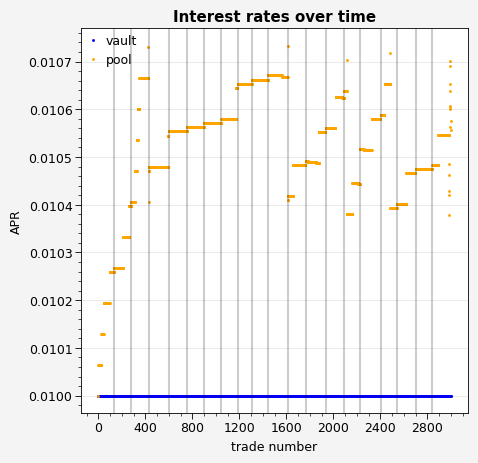

In [114]:
fig, axes, _ = get_gridspec_subplots()
# turn off vertical gridlines
axes[0].grid(axis="x", which="both", color="black", alpha=0)
ax = axes[0]
start_index = 0
end_index = -1
spot_size = 2.
ax.scatter(trades.iloc[start_index:end_index]["run_trade_number"], trades.iloc[start_index:end_index]["vault_apr"], label="vault", c="blue", s=spot_size)
ax.scatter(trades.iloc[start_index:end_index]["run_trade_number"], trades.iloc[start_index:end_index]["pool_apr"], label="pool", c="orange", s=spot_size)

ax.set_title("Interest rates over time")
ax.set_xlabel("trade number")
ax.set_ylabel("APR")
ax.legend()
# draw vertical line on days
day_data=np.nonzero(np.array(trades.iloc[start_index:end_index]["day"].diff())==1)[0]
for x in day_data:
    ax.axvline(x, c="black", alpha=0.2)

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
fig.set_size_inches((5, 5))

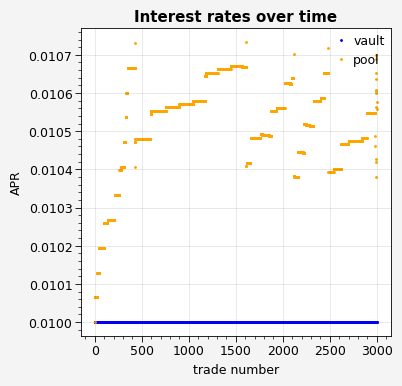

In [115]:
trades_agg = trades.groupby("day").agg(
    {
        "vault_apr": ["mean"],
        "pool_apr": ["mean"],
    }
)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()

fig, axes, _ = get_gridspec_subplots()
ax = axes[0]
start_index = 0
end_index = -1
spot_size = 2.
ax.scatter(trades.iloc[start_index:end_index]["run_trade_number"], trades.iloc[start_index:end_index]["vault_apr"], label="vault", c="blue", s=spot_size)
ax.scatter(trades.iloc[start_index:end_index]["run_trade_number"], trades.iloc[start_index:end_index]["pool_apr"], label="pool", c="orange", s=spot_size)
ax.set_title("Interest rates over time")
ax.set_xlabel("trade number")
ax.set_ylabel("APR")
ax.legend()
plt.show()

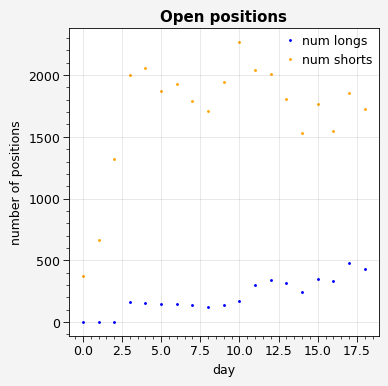

In [116]:
import pandas as pd
num_longs_and_shorts = {
    f"agent_{agent_id}_num_longs": ["sum"]
    for agent_id in range(len(simulator.agents))
}
num_longs_and_shorts.update({
    f"agent_{agent_id}_num_shorts": ["sum"]
    for agent_id in range(len(simulator.agents))
})
trades_agg = trades.groupby("day").agg(num_longs_and_shorts)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()
longs = trades_agg.filter(regex="num_longs").sum(axis=1)
shorts = trades_agg.filter(regex="num_shorts").sum(axis=1)
fix, axes, _ = output_utils.get_gridspec_subplots(nrows=1, ncols=1)
ax = axes[0]
spot_size = 2
ax.scatter(trades_agg["day"][:-1], longs[:-1], label="num longs", c="blue", s=spot_size)
ax.scatter(trades_agg["day"][:-1], shorts[:-1], label="num shorts", c="orange", s=spot_size)
ax.legend()
ax.set_xlabel("day")
ax.set_ylabel("number of positions")
text_handle = ax.set_title("Open positions")
fig.set_size_inches((5, 5))


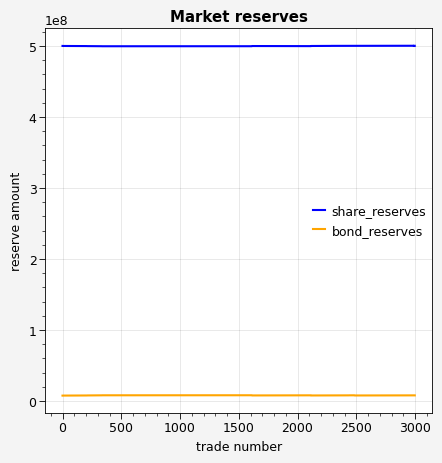

In [117]:
fig, axes, _ = output_utils.get_gridspec_subplots(nrows=1, ncols=1)
ax = trades.iloc[:-1].plot(x="run_trade_number", y="share_reserves", ax=axes[0], c="blue")
ax = trades.iloc[:-1].plot(x="run_trade_number", y="bond_reserves", ax=axes[0], c="orange")
ax.set_xlabel("trade number")
ax.set_ylabel("reserve amount")
ax.set_title("Market reserves")
fig.set_size_inches((5, 5))

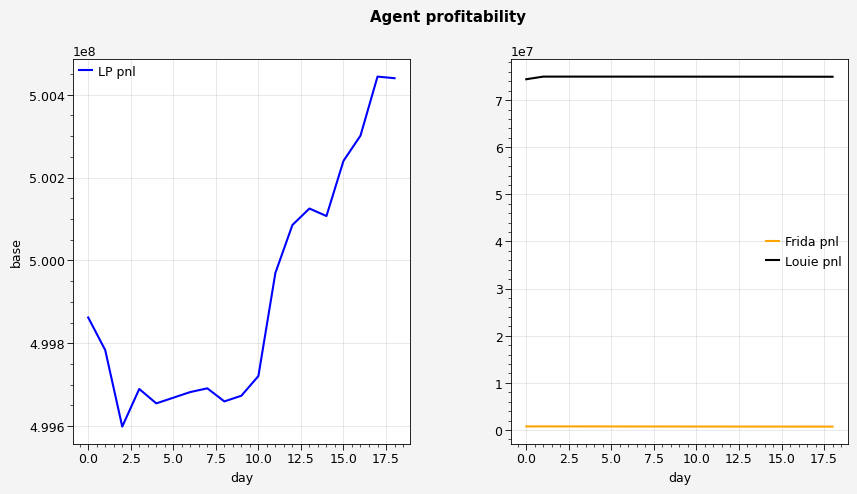

In [118]:
lp_trades = trades.groupby("day").agg(
    {
        f"agent_{0}_pnl": ["mean"]
    }
)
lp_trades.columns = ["_".join(col).strip() for col in lp_trades.columns.values]
lp_trades = lp_trades.reset_index()

fridas = [agent_id for agent_id in range(len(simulator.agents)) if simulator.agents[agent_id].__class__.__name__ == "FixedFrida"]
frida_trades = trades.groupby("day").agg(
    {
        f"agent_{agent_id}_pnl": ["mean"]
        for agent_id in fridas
    }
)
frida_trades.columns = ["_".join(col).strip() for col in frida_trades.columns.values]
frida_trades = frida_trades.reset_index()

louies = [agent_id for agent_id in range(len(simulator.agents)) if simulator.agents[agent_id].__class__.__name__ == "LongLouie"]
louies_trades = trades.groupby("day").agg(
    {
        f"agent_{agent_id}_pnl": ["mean"]
        for agent_id in louies
    }
)
louies_trades.columns = ["_".join(col).strip() for col in louies_trades.columns.values]
louies_trades = louies_trades.reset_index()

fig, axes, _ = output_utils.get_gridspec_subplots(nrows=1, ncols=2, wspace=0.3)

ax = axes[0]
ax.plot(trades_agg["day"][:-1], lp_trades.sum(axis=1)[:-1], label="LP pnl", c="blue")
ax.set_ylabel("base")

ax = axes[1]
ax.plot(trades_agg["day"][:-1], frida_trades.sum(axis=1)[:-1], label="Frida pnl", c="orange")
ax.plot(trades_agg["day"][:-1], louies_trades.sum(axis=1)[:-1], label="Louie pnl", c="black")

for ax in axes:
    ax.set_xlabel("day")
    ax.legend()
text_handle = fig.suptitle("Agent profitability")
fig.set_size_inches((10, 5))

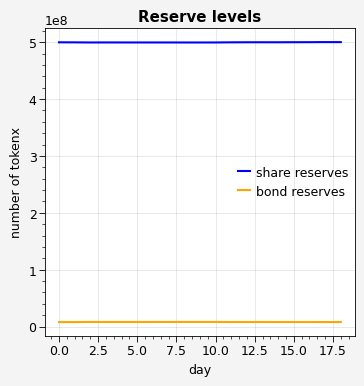

In [119]:
trades_agg = trades.groupby("day").agg(
    {
        "share_reserves": ["mean"],
        "bond_reserves": ["mean"]
    }
)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()
fix, axes, _ = output_utils.get_gridspec_subplots(nrows=1, ncols=1)
ax = trades_agg.iloc[:-1].plot(x="day", y="share_reserves_mean", ax=axes[0], label="share reserves", c="blue")
ax = trades_agg.iloc[:-1].plot(x="day", y="bond_reserves_mean", ax=axes[0], label="bond reserves", c="orange")
ax.set_xlabel("day")
ax.set_ylabel("number of tokenx")
text_handle = ax.set_title("Reserve levels")
fig.set_size_inches((5, 5))

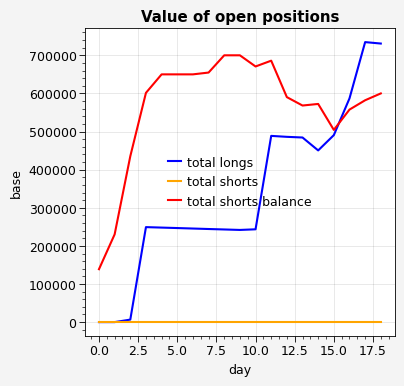

In [120]:
total_longs_and_shorts = { 
    f"agent_{agent_id}_total_longs": ["mean"] # total_longs is an aggregate value recomputed each trade
    for agent_id in range(len(simulator.agents))
}
total_longs_and_shorts.update({
    f"agent_{agent_id}_total_shorts": ["mean"] # total_shorts is an aggregate value recomputed each trade
    for agent_id in range(len(simulator.agents))
})
total_longs_and_shorts.update({
    f"agent_{agent_id}_total_shorts_balance": ["mean"] # shorts_balance is an aggregate value recomputed each trade
    for agent_id in range(len(simulator.agents))
})
trades_agg = trades.groupby("day").agg(total_longs_and_shorts)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()
longs = trades_agg.filter(regex="total_longs").sum(axis=1)
shorts = trades_agg.filter(regex="total_shorts$").sum(axis=1)
shorts_balance = trades_agg.filter(regex="total_shorts_balance").sum(axis=1)
fix, axes, _ = output_utils.get_gridspec_subplots(nrows=1, ncols=1)
ax = axes[0]
ax.plot(trades_agg["day"][:-1], longs[:-1], label="total longs", c="blue")
ax.plot(trades_agg["day"][:-1], shorts[:-1], label="total shorts", c="orange")
ax.plot(trades_agg["day"][:-1], shorts_balance[:-1], label="total shorts balance", c="red")
ax.legend()
ax.set_xlabel("day")
ax.set_ylabel("base")
text_handle = ax.set_title("Value of open positions")
fig.set_size_inches((5, 5))

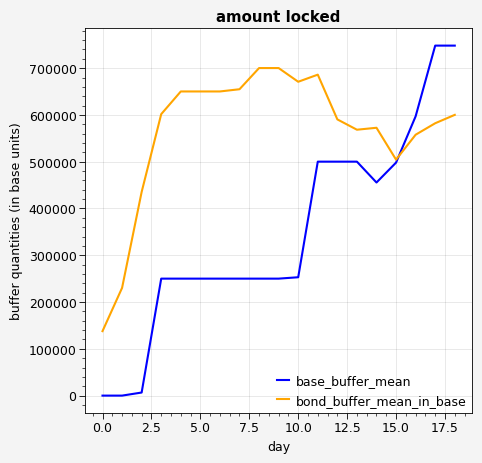

In [121]:
trades_agg = trades.groupby("day").agg(
    {
        "base_buffer": ["mean"],
        "bond_buffer": ["mean"],
        "spot_price": ["mean"],
    }
)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()
trades_agg["bond_buffer_mean_in_base"] = trades_agg["bond_buffer_mean"] / trades_agg["spot_price_mean"]

fig, axes, _ = output_utils.get_gridspec_subplots()
ax = trades_agg.iloc[:-1].plot(x="day", y="base_buffer_mean", ax=axes[0], c="blue")
ax = trades_agg.iloc[:-1].plot(x="day", y="bond_buffer_mean_in_base", ax=axes[0], c="orange")
text_handle = ax.set_title("amount locked")
ax.set_xlabel("day")
ax.set_ylabel("buffer quantities (in base units)")
fig.set_size_inches((5, 5))

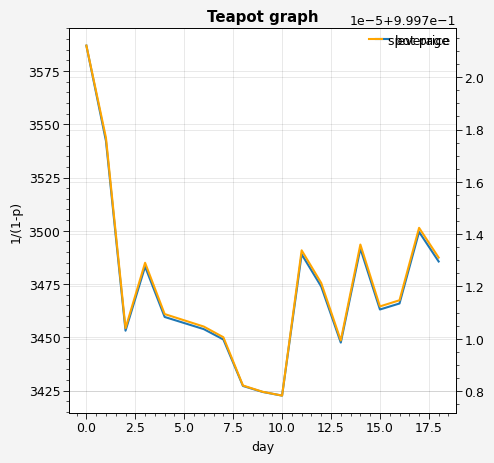

In [122]:
trades_agg = trades.groupby("day").agg(
    {
        "spot_price": ["mean"]
    }
)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()
trades_agg["leverage"] = 1 / (1 - trades_agg["spot_price_mean"])

fig, axes, _ = output_utils.get_gridspec_subplots()
ax = axes[0]
ax.plot(trades_agg["day"][:-1], trades_agg["leverage"][:-1])
ax.legend(["leverage"])
# plot on secondary axis
ax2 = ax.twinx()
ax2.plot(trades_agg["day"][:-1], trades_agg["spot_price_mean"][:-1], c="orange")
ax2.legend(["spot price"], loc="upper right")
text_handle = ax.set_title("Teapot graph")
ax.set_xlabel("day")
ax.set_ylabel("1/(1-p)")
fig.set_size_inches((5, 5))

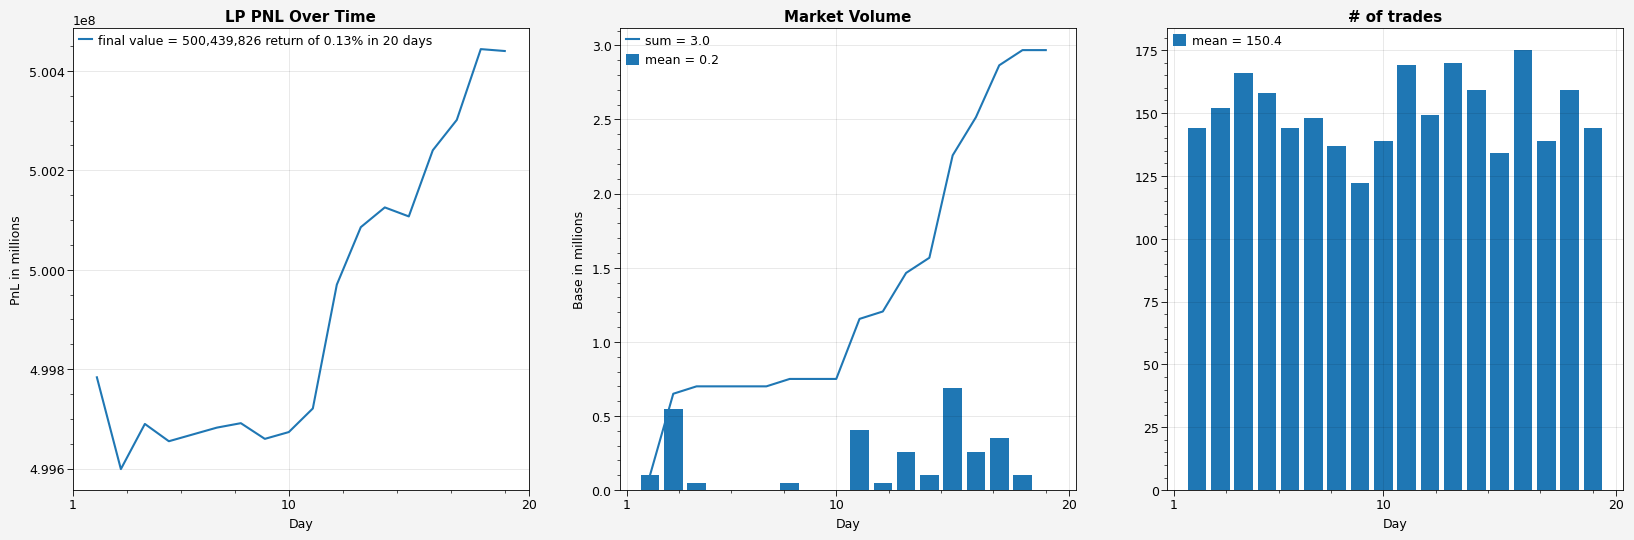

In [124]:
# === GET THE DATA ===
# aggregate data
keep_columns = [
    "day",
]
trades_agg = trades.groupby(keep_columns).agg(
    {
        'spot_price': ['mean'],
        'delta_base_abs': ['sum','count'],
        'share_reserves': ['mean'],
        'bond_reserves': ['mean'],
        'lp_reserves': ['mean'],
        'agent_0_pnl_no_mock': ['mean'],
    }
)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()
# display(trades_agg.head(5))
# display(trades_agg.columns)

# === PLOT THE GRAPH ===
fig, ax = plt.subplots(1,3,figsize=(20,6))
exclude_last_day = True
exclude_first_day = True
num_agents = 1
start_idx = 0 if exclude_first_day is False else 1
first_trade_that_is_on_last_day = min(trades_agg.index[trades_agg.day == max(trades_agg.day)])
end_idx = len(trades_agg) - 2 if exclude_last_day is True else len(trades_agg)-1
data = trades_agg.loc[start_idx:end_idx,"agent_0_pnl_no_mock_mean"]

# first subplot
ax[0].plot(trades_agg.loc[start_idx:end_idx,"day"], data, label=f"mean = {trades_agg.loc[end_idx,'agent_0_pnl_no_mock_mean']:.3f}")
ax[0].set_title("LP PNL Over Time")
ax[0].set_ylabel("PNL")
ax[0].set_xlabel("Day")
xtick_step = 10
ax[0].set_xticks([0]+[x for x in range(9, config.num_trading_days + 1, xtick_step)])
ax[0].set_xticklabels(['1']+[str(x+1) for x in range(9, config.num_trading_days + 1, xtick_step)])
final_value = data.values[len(data)-1]
starting_value = data.values[0]
ax[0].legend({f"final value = {final_value:,.0f} return of {final_value/starting_value-1:.2%} in {config.num_trading_days} days"})
ax[0].set_ylabel("PnL in millions")

# second subplot
divisor = 1e6
ydata = trades_agg.loc[start_idx:end_idx,"delta_base_abs_sum"]/divisor
ax[1].bar(trades_agg.loc[start_idx:end_idx,"day"],\
    ydata,\
    label=f"mean = {ydata.mean():,.1f}")
ax[1].plot(trades_agg.loc[start_idx:end_idx,"day"],\
    ydata.cumsum(),\
    label=f"sum = {ydata.sum():,.1f}")
ax[1].legend(loc='best')
ax[1].set_title("Market Volume")
ax[1].set_ylabel("Base in millions")
ax[1].set_xlabel("Day")
xtick_step = 10
ax[1].set_xticks([0]+[x for x in range(9, config.num_trading_days + 1, xtick_step)])
ax[1].set_xticklabels(['1']+[str(x+1) for x in range(9, config.num_trading_days + 1, xtick_step)])
ylim = ax[1].get_ylim()
ax[1].set_ylim(0, ylim[1])

# third subplot
ax[2].bar(trades_agg.loc[start_idx:end_idx,"day"],\
    trades_agg.loc[start_idx:end_idx,"delta_base_abs_count"],\
    label=f"mean = {trades_agg.loc[start_idx:end_idx,'delta_base_abs_count'].mean():,.1f}")
ax[2].legend(loc='best')
ax[2].set_title("# of trades")
ax[2].set_xlabel("Day")
xtick_step = 10
ax[2].set_xticks([0]+[x for x in range(9, config.num_trading_days + 1, xtick_step)])
ax[2].set_xticklabels(['1']+[str(x+1) for x in range(9, config.num_trading_days + 1, xtick_step)])
ylim = ax[2].get_ylim()
ax[2].set_ylim(0, ylim[1])

plt.show()